In [1]:
!which python

/Users/kmt/miniconda3/envs/drivesims/bin/python


In [1]:
# import plotly.express as px
# gapminder = px.data.gapminder()
# px.scatter(gapminder, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

In [1]:
import pandas as pd
import numpy as np
from numpy.random import choice
from random import random, randint, sample
from collections import defaultdict
import scipy.stats

In [2]:
import multiprocessing
import sys
import collections
from random import random
from time import sleep
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#import matplotlib.animation as animation

from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib.lines import Line2D

import seaborn as sns
sns.set()
# sns.set_style('whitegrid')
# sns.set_style('dark')

#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
colors = sns.color_palette("Set1", 9)
#colors = sns.color_palette("rainbow", 8)

#sns.palplot(colors)

In [3]:
%matplotlib inline
# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
# set_matplotlib_formats('svg', 'pdf')


We can sample drives between 0 and 1 from a beta:

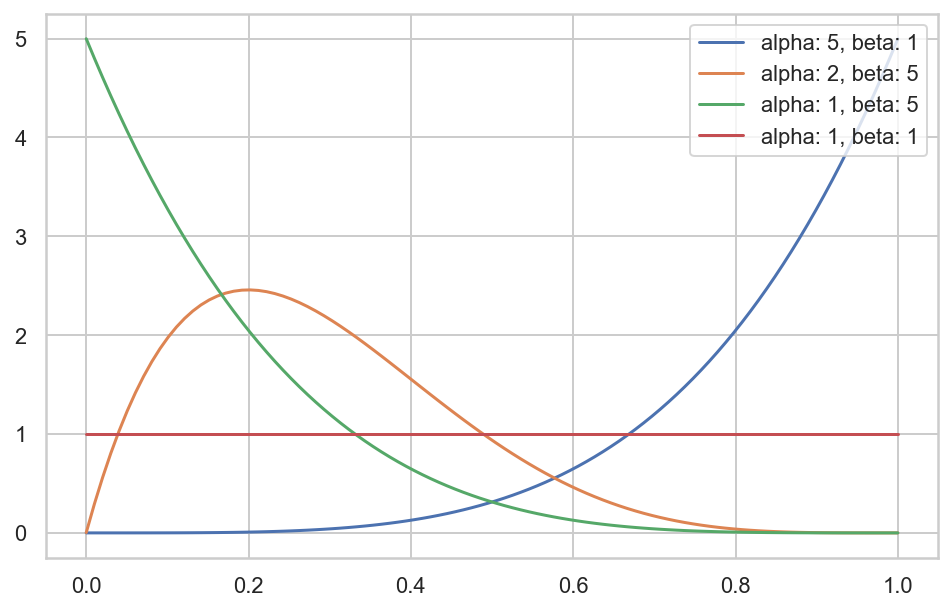

In [4]:
plt.figure(figsize=(8, 5))
x = np.linspace(0.0001, 0.9999, 100)
with sns.axes_style('whitegrid'):
    for a, b in [(5, 1), (2, 5), (1, 5), (1, 1)]:
        plt.plot(x, scipy.stats.beta.pdf(x, a, b), label='alpha: {}, beta: {}'.format(a, b))
    plt.legend(loc='upper right') ;

... but it does not matter which distribution such allele specivic values are drawn from. When we compute drive as `x_drive / (x_drive + y_drive)` this is always uniform:

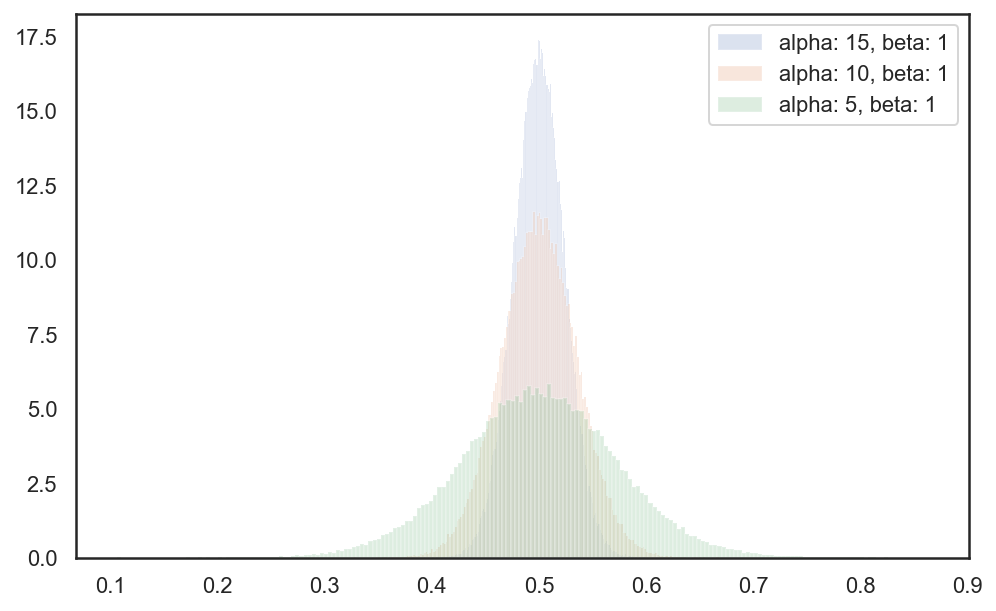

In [5]:
plt.figure(figsize=(8, 5))
with sns.axes_style('white'):
    x = np.linspace(0.0001, 0.9999, 100000)
    for a, b in [(15, 1), (10, 1), (5, 1)]:
        x_drive = abs(np.random.normal(a, b, size=len(x)))
        y_drive = abs(np.random.normal(a, b, size=len(x)))
        plt.hist(x_drive / (x_drive + y_drive), density=True, bins=200, alpha=0.2, label='alpha: {}, beta: {}'.format(a, b))
    plt.legend() ;

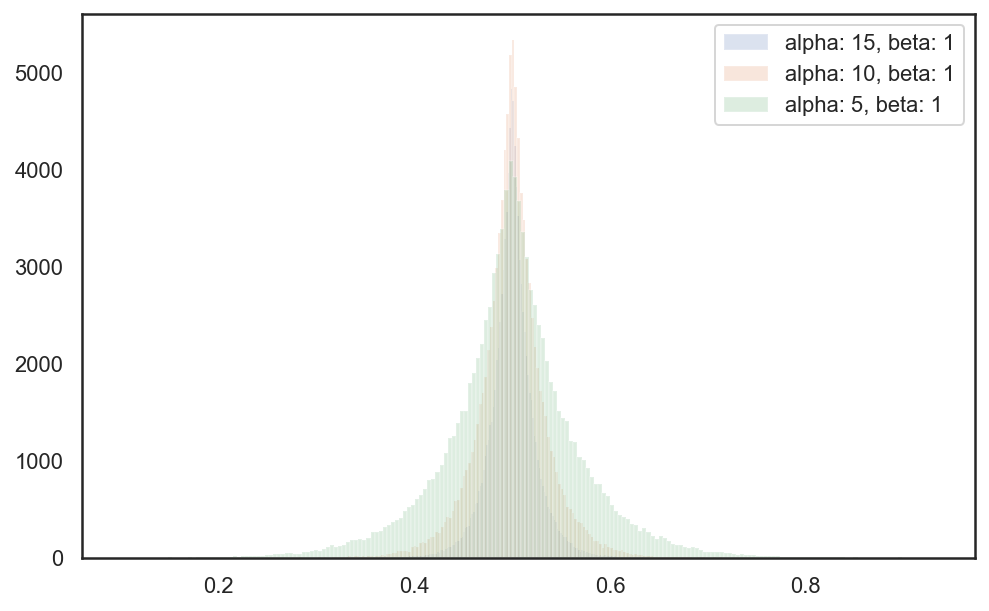

In [6]:
plt.figure(figsize=(8, 5))
with sns.axes_style('white'):
    x = np.linspace(0.0001, 0.9999, 100000)
    for a, b in [(15, 1), (10, 1), (5, 1)]:
        x_drive = np.random.beta(a, b, size=len(x))
        y_drive = np.random.beta(a, b, size=len(x))
        plt.hist(x_drive / (x_drive + y_drive), bins=200, alpha=0.2, label='alpha: {}, beta: {}'.format(a, b))
    plt.legend() ;

In [8]:
%matplotlib widget

class Allele:
    
    def __init__(self, chrom, label, val):
        self.chrom = chrom
        self.label = label
        self.val = val
    
class Male:
    
    def __init__(self, x_allele, y_allele):
        assert x_allele.chrom == 'X'
        assert y_allele.chrom == 'Y'
        self.x_allele = x_allele
        self.y_allele = y_allele

    def __add__(self, female):
        tot_val = self.x_allele.val + self.y_allele.val

        x_drive = Population.DRIVES[self.x_allele.label][self.y_allele.label]
        y_drive = Population.DRIVES[self.y_allele.label][self.x_allele.label]

        x_proportion = x_drive / (x_drive + y_drive)
                
        if random() < x_proportion:
            sperm_allele = self.x_allele
        else:
            sperm_allele = self.y_allele

        if random() < 0.5:
            egg_allele = female.x1_allele
        else:        
            egg_allele = female.x2_allele
  
        if sperm_allele.chrom == 'Y':
            return Male(egg_allele, sperm_allele)
        else:
            return Female(egg_allele, sperm_allele)
            
class Female:

    def __init__(self, x1_allele, x2_allele):
        assert x1_allele.chrom == 'X'
        assert x2_allele.chrom == 'X'
        self.x1_allele = x1_allele
        self.x2_allele = x2_allele

    def __add__(self, male):
        return male + self
        
class Population:
    
    DRIVES = pd.DataFrame()
        
    def __init__(self, males=[], females=[], cur_xlabel=0, cur_ylabel=1, alpha=5, beta=1):
        self.males = males
        self.females = females
        self.alpha = alpha
        self.beta = beta
        self.pop_size = len(self.males) + len(self.females)
        self.drive_coef = defaultdict(dict)
        self.cur_xlabel = cur_xlabel # label of latest x allele
        self.cur_ylabel = cur_ylabel # label of latest y allele
        
    def initialize(self, pop_size):
        assert not pop_size % 2, 'initial pop_size must be even'
        self.males = [Male(Allele('X', self.cur_xlabel, 1), 
                           Allele('Y', self.cur_ylabel, 1)) for _ in range(pop_size//2)]
        self.females = [Female(Allele('X', self.cur_xlabel, 1), 
                               Allele('X', self.cur_xlabel, 1)) for _ in range(pop_size//2)]

        self.update_drives(self.cur_xlabel)
        self.update_drives(self.cur_ylabel)

    def update_drives(self, label):    
        assert label not in Population.DRIVES.columns.values
        nrows, ncols = self.DRIVES.shape
#         Population.DRIVES[label] = np.random.beta(self.alpha, self.beta, size=nrows)
        Population.DRIVES[label] = np.random.normal(self.alpha, self.beta, size=nrows)
        nrows, ncols = Population.DRIVES.shape
#         new_row = pd.DataFrame.from_records([np.random.beta(self.alpha, self.beta, size=ncols)], 
#                                             columns=Population.DRIVES.columns)
        new_row = pd.DataFrame.from_records([np.random.normal(self.alpha, self.beta, size=ncols)], 
                                            columns=Population.DRIVES.columns)
        new_row.index = [label]
        Population.DRIVES = pd.concat([Population.DRIVES, new_row])
        Population.DRIVES = Population.DRIVES.copy()
        
    def resample(self, new_pop_size=None):
        if new_pop_size is None:
            new_pop_size = self.pop_size
        new_males = list()
        new_females = list()

        ##############        
#         def child(male, female):
#             return male + female
            
#         for i in range(new_pop_size):
#             child = sample_child()
#             if isinstance(child, Male):
#                 new_males.append(child)
#             else:
#                 new_females.append(child) 
            
#         with multiprocessing.Pool(2) as p:
#             for child in p.map(sample_child, range(new_pop_size)):
#                 if isinstance(child, Male):
#                     new_males.append(child)
#                 else:
#                     new_females.append(child)  
                
        ##############
        
#         for father, mother in zip(random.choices(males, k=len(males)), random.choices(females, k=len(females))):
        for i in range(new_pop_size):
            male = self.males[int(random() * len(self.males))]
            female = self.females[int(random() * len(self.females))]
#             male = self.males[randint(0, len(self.males)-1)]
#             female = self.females[randint(0, len(self.females)-1)]
            child = male + female
                        
            if isinstance(child, Male):
                new_males.append(child)
            else:
                new_females.append(child) 
                
        return Population(new_males, new_females, self.cur_xlabel, self.cur_ylabel)

    def mutate(self, x_mut_prob, y_mut_prob):
        for i in range(len(self.males)):
            if random() < x_mut_prob:
                self.cur_xlabel += 2
                self.males[i].x_allele = Allele('X', self.cur_xlabel, 1)
                
                self.update_drives(self.cur_xlabel)
                
            if random() < y_mut_prob:
                self.cur_ylabel += 2
                self.males[i].y_allele = Allele('Y', self.cur_ylabel, 1)

                self.update_drives(self.cur_ylabel)

        for i in range(len(population.females)):
            if random() < x_mut_prob:
                self.cur_xlabel += 2
                self.females[i].x1_allele = Allele('X', self.cur_xlabel, 1)
                
                self.update_drives(self.cur_xlabel)
                
            if random() < x_mut_prob:
                self.cur_xlabel += 2
                self.females[i].x2_allele = Allele('X', self.cur_xlabel, 1)
                
                self.update_drives(self.cur_xlabel)
                        
    def x_freqs(self):
        alleles = [male.x_allele.label for male in self.males] + \
            [female.x1_allele.label for female in self.females] + \
            [female.x2_allele.label for female in self.females]
        unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
        return unique_elements, counts_elements / counts_elements.sum()

    def y_freqs(self):
        alleles = [male.y_allele.label for male in self.males]
        unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
        return unique_elements, counts_elements / counts_elements.sum()

    def male_freq(self):
        return len(self.males) / (len(self.males) + len(self.females))


sns.set_style('white')
    
# Set up figure with lines and corresponding data structures:
# fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, figsize=(12,10))
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12,7))
xwidth = 50
ax1.set_xlim(0, xwidth)
plt.tight_layout()

# add lines to plot: 
# lines are added in same order as x_data and y_data lists
# because dicts are ordered this means that x_data and y_data
# refer to the same lines in each frame e.g.: zip(lines, x_data.values(), y_data.values())
# In hartheat you then just need to add data to right coordinate lists using the key labels.

lines = list()
x_data = collections.OrderedDict()
y_data = collections.OrderedDict()

linewidth = 2

# for second ax 
ax3.set_title('Number of alleles', loc='left')
#ax3.set_ylim(0, 150)
ax3.set_ylim(0, 50)
line = Line2D([], [], color=colors[0], linewidth=linewidth)
ax3.add_line(line)
lines.append(line)
x_data['nr_x_alleles'] = []
y_data['nr_x_alleles'] = []
line = Line2D([], [], color=colors[0], linewidth=linewidth, linestyle='dashed')
ax3.add_line(line)
lines.append(line)
x_data['nr_y_alleles'] = []
y_data['nr_y_alleles'] = []

# for third ax 
ax4.set_title('Male frequency', loc='left')
line = Line2D([], [], color=colors[1], linewidth=linewidth)
ax4.add_line(line)
lines.append(line)
x_data['male_freq'] = []
y_data['male_freq'] = []

# for fourth ax 
ax5.set_title('Population size', loc='left')
line = Line2D([], [], color=colors[2], linewidth=linewidth)
ax5.add_line(line)
ax5.set_ylim(0, 31000)
lines.append(line)
x_data['pop_size'] = []
y_data['pop_size'] = []

# ax6.set_title('Mean X transmission')
# line = Line2D([], [], color=colors[0], linewidth=linewidth)
# ax6.add_line(line)
# ax6.set_ylim(0, 1)
# lines.append(line)
# x_data['mean_ratio'] = []
# y_data['mean_ratio'] = []
# # line = Line2D([], [], color=colors[0], linewidth=1, linestyle='dashed')
# # ax6.add_line(line)
# # lines.append(line)
# # x_data['y_val_mean'] = []
# # y_data['y_val_mean'] = []
# ax6.axhline(null_dist.mean(), color='black', linewidth=1, linestyle='dashed', zorder=0)

# ax7.set_title('SD X transmission')
# line = Line2D([], [], color=colors[0], linewidth=linewidth)
# ax7.add_line(line)
# ax7.set_ylim(0, .5)
# lines.append(line)
# x_data['sd_ratio'] = []
# y_data['sd_ratio'] = []
# # line = Line2D([], [], color=colors[0], linewidth=1, linestyle='dashed')
# # ax7.add_line(line)
# # lines.append(line)
# # x_data['y_val_sd'] = []
# # y_data['y_val_sd'] = []
# ax7.axhline(null_dist.std(), color='black', linewidth=1, linestyle='dashed', zorder=0)

ax1.set_title('X Allele frequencies:', loc='left')
ax1.set_ylim(0, 1.05)

ax2.set_title('Y Allele frequencies:', loc='left')
ax2.set_ylim(0, 1.05)

nr_lines = 50000
# for first ax (we add these last becuase we will not use all of them)
for i in range(0, nr_lines, 2):
    line = Line2D([], [], color=colors[int(i%8)], linewidth=linewidth)
    ax1.add_line(line)
    lines.append(line)    
    x_data[i] = []
    y_data[i] = []

for i in range(1, nr_lines, 2):
    line = Line2D([], [], color=colors[int(i%8)], linewidth=linewidth)
    ax2.add_line(line)
    lines.append(line)    
    x_data[i] = []
    y_data[i] = []

#pop_size_history = [1000] * 300 + [10000] * 1000
#pop_size_history = [1000] * 200 + [100] * 200 + [1000] * 1000
# pop_size_history = [10000] * 300 + [2000] * 300 + [10000] * 200
#pop_size_history = [10000] * 1600
pop_size_history = [2000] * 1000

# pop_size_history = [2000] * 1600 + [100] * 600 + [2000] * 1000
# x_mutation_rate = 0.0001
# y_mutation_rate = 0.0005

pop_size_history = [20000] * 1000
x_mutation_rate = 0.001
y_mutation_rate = 0.001

# alpha = 1
# beta = 5
alpha = 5
beta = 1

# _x = np.random.beta(alpha, beta, size=100000)
# _y = np.random.beta(alpha, beta, size=100000)
_x = np.random.normal(alpha, beta, size=100000)
_y = np.random.normal(alpha, beta, size=100000)
null_dist = _x / (_x + _y)


population = Population(alpha=alpha, beta=beta)
population.initialize(pop_size_history.pop(0))
    
# Define a callback function, `hartbeat`, that is called once for 
# every frame of the animation to populate `x_data` and `y_data`:

def generation(gen):
    global population

    pop_size = pop_size_history.pop(0)
    population = population.resample(pop_size)

#     if 300 <= gen < 600:
    if False:
        population.mutate(x_mut_prob=100*x_mutation_rate, y_mut_prob=100*y_mutation_rate)
    else:
        population.mutate(x_mut_prob=x_mutation_rate, y_mut_prob=y_mutation_rate)

    x_alleles, x_freqs = population.x_freqs()
    y_alleles, y_freqs = population.y_freqs()
        
    for x_allele, x_freq in zip(x_alleles, x_freqs):
        print(x_data)
        x_data[x_allele].append(gen)
        y_data[x_allele].append(x_freq)

    for y_allele, y_freq in zip(y_alleles, y_freqs):
        x_data[y_allele].append(gen)
        y_data[y_allele].append(y_freq)

    y_data['male_freq'].append(population.male_freq())
    x_data['male_freq'].append(gen)

    y_data['nr_x_alleles'].append(len(x_alleles))
    x_data['nr_x_alleles'].append(gen)
    y_data['nr_y_alleles'].append(len(y_alleles))
    x_data['nr_y_alleles'].append(gen)

    y_data['pop_size'].append(pop_size)
    x_data['pop_size'].append(gen)
    
#     x_vals = population.DRIVES.loc[x_alleles, y_alleles].as_matrix()
#     y_vals = population.DRIVES.loc[y_alleles, x_alleles].as_matrix()
#     ratios = x_vals / (x_vals + y_vals.T)
#     ratios_mean = (np.outer(x_freqs, y_freqs) * ratios).sum()
#     ratios_sd = np.sqrt((np.outer(x_freqs, y_freqs) * (ratios.mean() - ratios)**2).sum())
#     y_data['mean_ratio'].append(ratios_mean)
#     x_data['mean_ratio'].append(gen)
#     y_data['sd_ratio'].append(ratios_sd)
#     x_data['sd_ratio'].append(gen)
    
    
    # interrogate y and x data to see age of oldest allele among current alleles.
    
    
    # recycle lines not used any more
    
    return x_data, y_data


# Run the animation:

def init():  # only required for blitting to give a clean slate.

    for line in lines:
        line.set_data([], [])
#         line.set_ydata([np.nan] * xwidth)
#         line.set_xdata([])
#         line.set_ydata([])
    return lines

def animate(i):
    x_data, y_data = generation(i)

    xmin, xmax = fig.axes[0].get_xlim()
    if i > xmax:
        fig.axes[0].set_xlim(xmin, xmax+xmax)
#        fig.canvas.draw() 

    
    for j, (x, y) in enumerate(zip(x_data.values(), y_data.values())):
        if i == 0 or y and y[-1] > 0:
            lines[j].set_xdata(x)
            lines[j].set_ydata(y)
            
    return lines

anim = animation.FuncAnimation(
        fig, animate, init_func=init, #frames=100, 
    interval=50, blit=True, save_count=400)

fig.suptitle("x rate: {}, y rate: {}, alpha: {}, beta: {}".format(x_mutation_rate, y_mutation_rate, alpha, beta))
# plt.show()
plt.tight_layout()
plt.close()

matplotlib.rcParams['animation.embed_limit'] = 400

# matplotlib.rcParams['animation.html'] = 'jshtml'
# anim

HTML(anim.to_jshtml())

AssertionError: 

In [28]:
fig.savefig('simulation.svg')
fig.savefig('simulation.pdf')

In [ ]:
anim.save('animation)

In [36]:
writervideo = animation.FFMpegWriter(fps=60)
anim.save('animation.mp4', writer=writervideo, dpi=254)

#animation.Animation.save(filename='animation.mp4', writer=writervideo, dpi=254)


IndexError: pop from empty list

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation


# def data_gen(t=0):
#     cnt = 0
#     while cnt < 1000:
#         cnt += 1
#         t += 0.1
#         yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


# def init():
#     ax.set_ylim(-1.1, 1.1)
#     ax.set_xlim(0, 10)
#     del xdata[:]
#     del ydata[:]
#     line.set_data(xdata, ydata)
#     return line,

# fig, ax = plt.subplots()
# line, = ax.plot([], [], lw=2)
# ax.grid()
# xdata, ydata = [], []


# def run(data):
#     # update the data
#     t, y = data
#     xdata.append(t)
#     ydata.append(y)
#     xmin, xmax = ax.get_xlim()

#     if t >= xmax:
#         ax.set_xlim(xmin, 2*xmax)
#         ax.figure.canvas.draw()
#     line.set_data(xdata, ydata)

#     return line,

# ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
#                               repeat=False, init_func=init)
# plt.show()

In [14]:
# population = Population(alpha=alpha, beta=beta)
# population.initialize(100)
# for i in range(10):
#     pop_size = 100
#     population = population.resample(pop_size)


How this could displace admixture:

Say you have a small admixed OOA population with a small standing variation on X and Y. And that you have a lot of variation already existing outside Africa in a highly nonadmixed structured population. Then these variants (both X and Y) would repeatedly be introduced into the small one and eventually one would be able to make a wave on X. That partial sweep would then be without admixture.

How to explain that there is no sweeps in Africa?


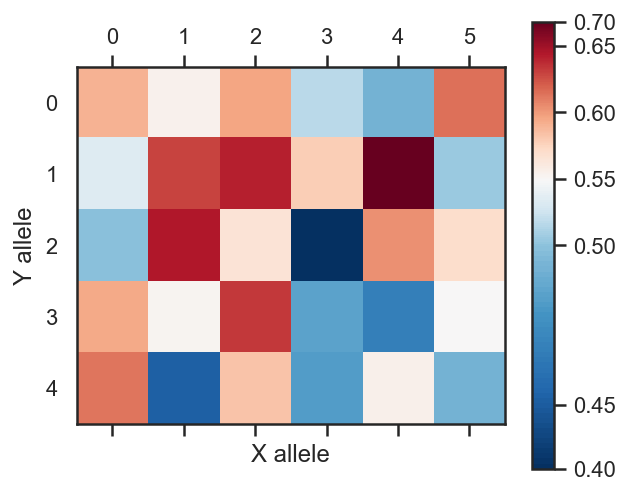

In [29]:
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

x_alleles, x_freqs = population.x_freqs()
y_alleles, y_freqs = population.y_freqs()
x_vals = population.DRIVES.loc[x_alleles, y_alleles].values
y_vals = population.DRIVES.loc[y_alleles, x_alleles].values
ratios = x_vals / (x_vals + y_vals.T)

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
with sns.axes_style('white'):
    plt.matshow(ratios.T, cmap=plt.get_cmap('RdBu_r'), norm=MidpointNormalize(midpoint=0.5))
    plt.colorbar()
    plt.xlabel('X allele')
    plt.ylabel('Y allele')

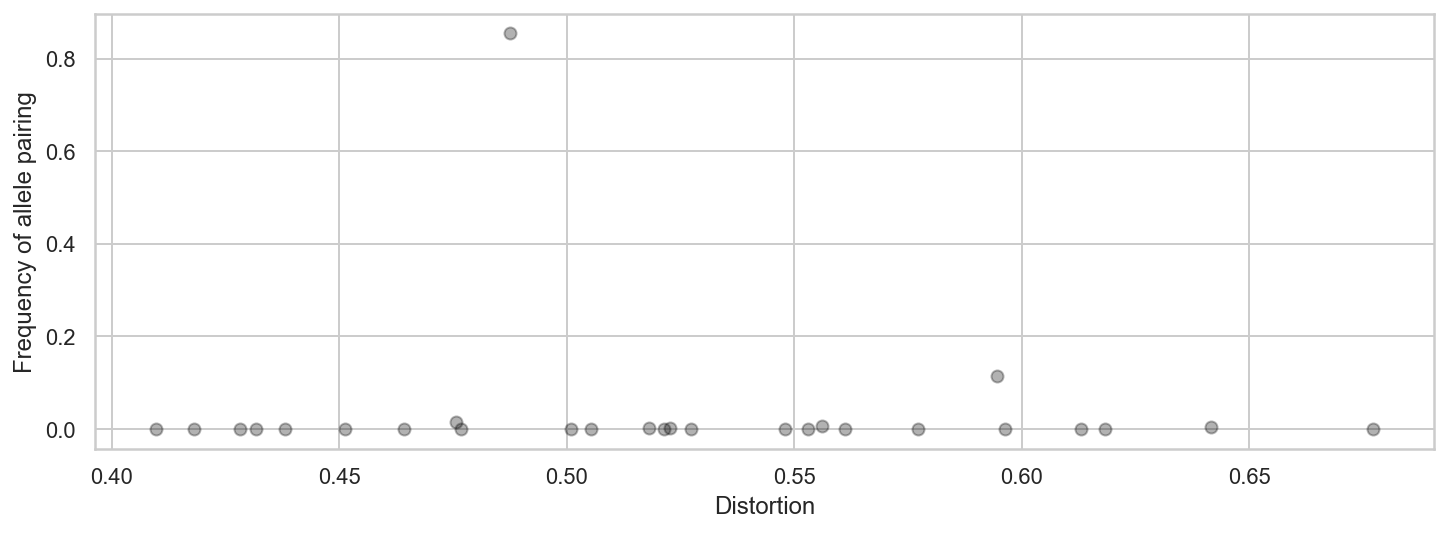

In [24]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12,4))
    plt.scatter(ratios.flatten(), np.outer(x_freqs, y_freqs).flatten(), color='black', alpha=0.3)
    plt.ylabel('Frequency of allele pairing')
    plt.xlabel('Distortion');

What proportion of mate pairs have an offspring sex-ratio distortion above 0.1 and 0.2:

In [25]:
f = pd.Series(np.outer(x_freqs, y_freqs).flatten())
s = pd.Series(ratios.flatten())
d = (s - 0.5).abs()
mask = d > 0.2
f.loc[d > 0.1].sum(), f.loc[d > 0.2].sum()

(0.005121781954698618, 0.0)

- It seems the ratio SD is quite insensitive to both the sampling distribution and population size. 
- What happens if we stop introducing mutations? For how long will polymorphism remain?

- With low mutation rate there is little defensive diversity and the there is at most only X and Y at at time. Rarely, a sweep intercepted by a standing variant.
- With higher y mutation rate, the male freq is above 0.5 on avg. If y rate is truely larger I wonder why real male ratio is 0.5. Maybe it is because the many other X loci contribute defensive diversity too.
- If the max drivce values are smaller (when 2 is added to each value before I compute drives), then there is lots more ballanced diversity, presumably because this is not removed by partial sweeps.
- but then when I recude mut rate to 0.0001, it turns dramatic again (fixed most of the time).

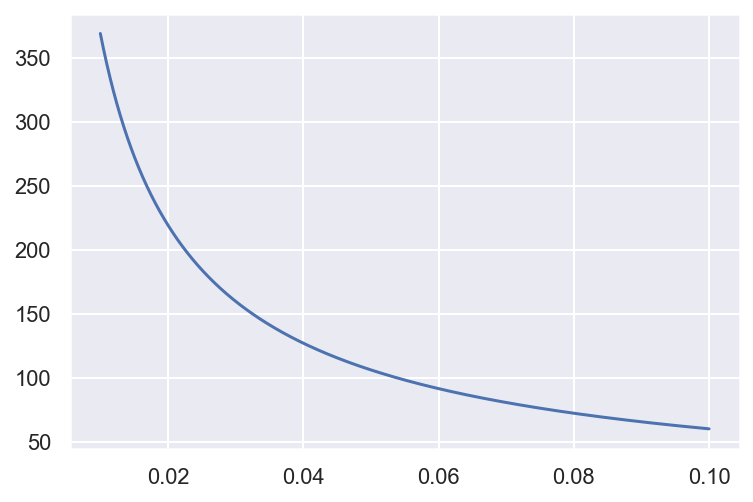

In [14]:
def fixation_time(s, N):
    return (1/s)*np.log(4*N*s) 
    
nr_points = 2000
s_arr = np.linspace(0.01, 0.1, num=nr_points)
N_arr = np.full(nr_points, 1000.0)
plt.plot(s_arr, fixation_time(s_arr, N_arr))
plt.show()

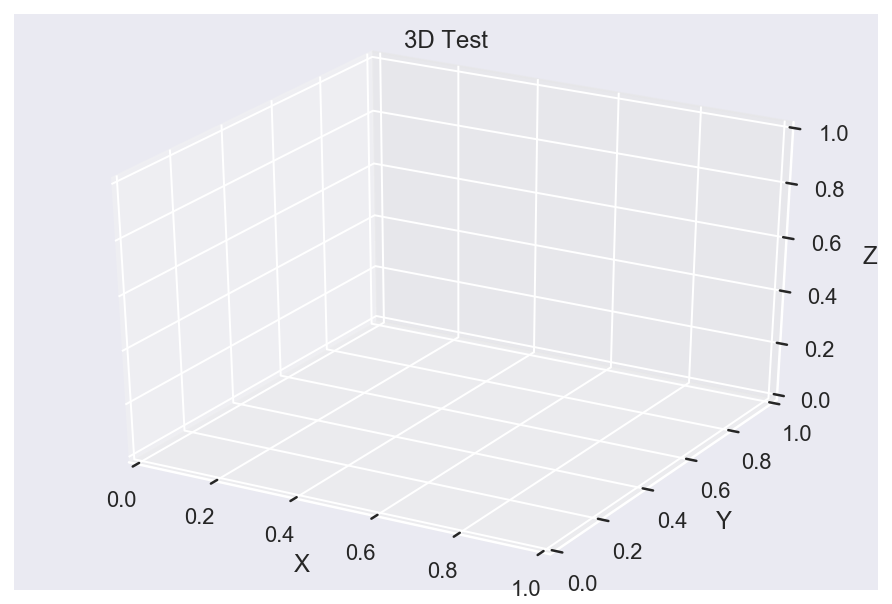

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                                   interval=50, blit=False)

plt.show()

TODO:

Would be cool If I could update

- An SFS
- Distribution of allele ages
- Drive statistics

- Model two populations that can then fused

- Maybe improve mutation model so that the drives of each new variant is not indpendent of it origin but a pertubation of the old drives.